In [1]:
# run pip install -r requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omarm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omarm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Download the punkt_tab resource that is needed for tokenization
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\omarm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
true_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

true_news['label'] = 1  # 1 for true news
fake_news['label'] = 0  # 0 for fake news

print(f"True news shape: {true_news.shape}")
print(f"Fake news shape: {fake_news.shape}")

True news shape: (21417, 5)
Fake news shape: (23481, 5)


In [5]:
true_news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
fake_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
news_dataset = pd.concat([true_news, fake_news], ignore_index=True)
news_dataset = news_dataset.sample(frac=1).reset_index(drop=True)
print(f"Total dataset shape: {news_dataset.shape}")

Total dataset shape: (44898, 5)


In [8]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^\s+|\s+?$', '', text)
    
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

In [9]:
news_dataset['cleaned_text'] = news_dataset['text'].apply(clean_text)
news_dataset['cleaned_title'] = news_dataset['title'].apply(clean_text)
news_dataset['combined_content'] = news_dataset['cleaned_title'] + ' ' + news_dataset['cleaned_text']

X = news_dataset['combined_content']
y = news_dataset['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (35918,)
Testing data shape: (8980,)


In [10]:
max_words = 50000
max_sequence_length = 300

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

Found 183364 unique tokens


In [11]:
embedding_dim = 128
vocab_size = min(max_words, len(word_index) + 1)

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.summary()

c:\Users\omarm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 201s 385ms/step - accuracy: 0.9379 - loss: 0.1384 - val_accuracy: 0.9986 - val_loss: 0.0035
Epoch 2/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 201s 385ms/step - accuracy: 0.9379 - loss: 0.1384 - val_accuracy: 0.9986 - val_loss: 0.0035
Epoch 2/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 196s 388ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.9994 - val_loss: 0.0036
Epoch 3/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 196s 388ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.9994 - val_loss: 0.0036
Epoch 3/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 200s 396ms/step - accuracy: 0.9998 - loss: 9.0504e-04 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 4/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 200s 396ms/step - accuracy: 0.9998 - loss: 9.0504e-04 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 4/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 200s 394ms/step - accuracy: 0.9999 - loss: 6.5661e-04 - val_accuracy: 0.9997 - val_loss: 0.0018
Epoch 5/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 200s 394ms/step - accura

In [15]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9987 - loss: 0.0110
Test Loss: 0.0126
Test Accuracy: 0.9986
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.9987 - loss: 0.0110
Test Loss: 0.0126
Test Accuracy: 0.9986


In [16]:
y_pred_proba = model.predict(X_test_padded)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4650
           1       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


Confusion Matrix:
[[4649    1]
 [  12 4318]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4650
           1       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980


Confusion Matrix:
[[4649    1]
 [  12 4318]]


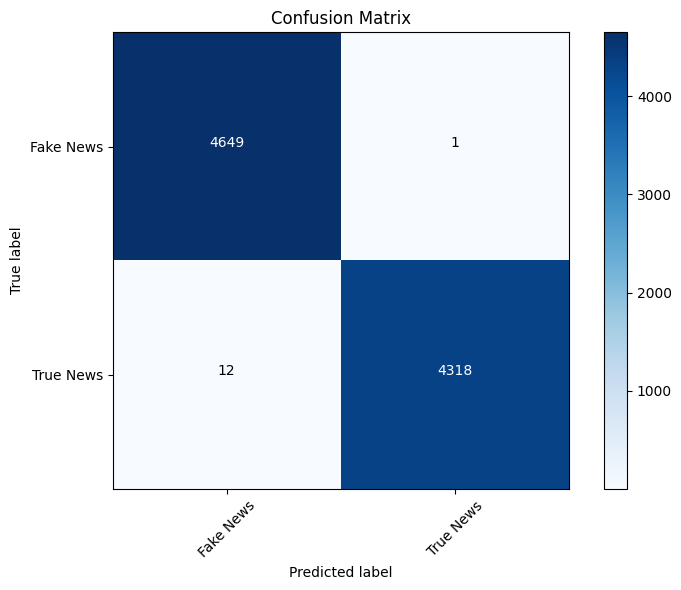

In [17]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Fake News', 'True News']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [18]:
model.save('fake_news_detector.h5')
print("Model saved as 'fake_news_detector.h5'")

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved as 'tokenizer.pickle'")

Model saved as 'fake_news_detector.h5'
Tokenizer saved as 'tokenizer.pickle'
Tokenizer saved as 'tokenizer.pickle'


In [23]:
def predict_news(news_text, model, tokenizer, max_seq_length=300):
    cleaned_text = clean_text(news_text)
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequences)[0][0]
    result = "True News" if prediction > 0.5 else "Fake News"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return result, confidence * 100

sample_fake_news = fake_news.iloc[0]['text']
sample_true_news = true_news.iloc[0]['text']

result_fake, confidence_fake = predict_news(sample_fake_news, model, tokenizer)
result_true, confidence_true = predict_news(sample_true_news, model, tokenizer)

print(f"Sample Fake News Prediction: {result_fake} with {confidence_fake:.2f}% confidence")
print(f"Sample True News Prediction: {result_true} with {confidence_true:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Sample Fake News Prediction: Fake News with 100.00% confidence
Sample True News Prediction: True News with 99.98% confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Sample Fake News Prediction: Fake News with 100.00% confidence
Sample True News Prediction: True News with 99.98% confidence
